## Hyperparameter tuning via Optuna

### Being a binary model this notebook will be limited to predicting one class 1 or 0, yes or no.
### Here I will be predicting if a cell received a treatment or not

In [1]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly
import pyarrow.parquet as pq
import seaborn as sns
import toml
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing
from sklearn.metrics import (
    auc,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split

sys.path.append("../..")
from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    data_split,
    extract_best_trial_params,
    objective_model_optimizer,
    optimized_model_create,
    parameter_set,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)

sys.path.append("../../../")
from utils.utils import df_stats

In [2]:
# Import Data
# set data file path under pathlib path for multi-system use


file_path = Path(
    "../../../../Extracted_Features_(CSV_files)/interstellar_wave3_sc_norm_fs_cellprofiler.csv.gz"
)

file_path = Path(
    "../../../../Extracted_Features_(CSV_files)/SHSY5Y_preprocessed_df_sc_norm.parquet"
)

df = pq.read_table(file_path).to_pandas()
# df = pd.read_csv(file_path, engine="pyarrow")

In [3]:
data = Path("../../MLP_utils/config.toml")
config = toml.load(data)
params = Parameters()
params = parameter_set(params, config)

#### Set up Data to be compatible with model

##### Classification Models:
Comment out code if using regression

In [4]:
# Generate df specific to analysis and model
df = df.query(
    "oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'LPS_100.000_DMSO_0.025'| oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'Thapsigargin_10.000_DMSO_0.025' | oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'DMSO_0.100_DMSO_0.025'"
)

print("Selected Catagories are:")
print(df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique())
# Check for Nans again
df_stats(df)

if params.DATA_SUBSET_OPTION == "True":
    df = df.sample(n=params.DATA_SUBSET_NUMBER)
    print("Data Subset Is On")
    print(f"Data is subset to {params.DATA_SUBSET_NUMBER}")
else:
    print("Data Subset Is Off")

Selected Catagories are:
['DMSO_0.100_DMSO_0.025' 'Thapsigargin_10.000_DMSO_0.025'
 'LPS_100.000_DMSO_0.025']
The dimensions of the data are: (64842, 2872)
Number of total missing values across all columns: 129684
Data Subset Is Off


In [5]:
np.random.seed(seed=0)
wells_to_hold = (
    df.groupby("oneb_Metadata_Treatment_Dose_Inhibitor_Dose")
    .agg(np.random.choice)["Metadata_Well"]
    .to_list()
)
df_holdout = df[df["Metadata_Well"].isin(wells_to_hold)]
df = df[~df["Metadata_Well"].isin(wells_to_hold)]


print("Wells held out for testing:", df_holdout["Metadata_Well"].unique())
print(
    "Wells to use for training, validation, and testing", df["Metadata_Well"].unique()
)

Wells held out for testing: ['I14' 'L14' 'J21']
Wells to use for training, validation, and testing ['B14' 'C14' 'E14' 'B15' 'C15' 'E15' 'J14' 'I15' 'J15' 'L15' 'J16' 'J17'
 'J20']


In [6]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df[df_metadata]
df_values = df.drop(columns=df_metadata)

In [7]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
)
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ],
    axis=1,
)
df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]

In [8]:
output_name = (" ").join(df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique())
title = f'{output_name.split(" ")[0].split("_")[0]} vs {(" ").join(output_name.split(" ")[1].split("_")[:2])} vs {(" ").join(output_name.split(" ")[2].split("_")[:2])}'

#### Split Data - All Models can proceed through this point

In [9]:
X_train, X_test, X_val, Y_train, Y_test, Y_val = data_split(
    X_vals=df_values_X,
    y_vals=df_values_Y,
    train_proportion=0.8,
    val_proportion=0.1,
    test_proportion=0.1,
    seed=1,
    params=params,
)

In [10]:
# produce data objects for train, val and test datasets
train_data = Dataset_formatter(
    torch.FloatTensor(X_train.values), torch.FloatTensor(Y_train.values)
)
val_data = Dataset_formatter(
    torch.FloatTensor(X_val.values), torch.FloatTensor(Y_val.values)
)
test_data = Dataset_formatter(
    torch.FloatTensor(X_test.values), torch.FloatTensor(Y_test.values)
)

In [11]:
params.IN_FEATURES = X_train.shape[1]
print("Number of in features: ", params.IN_FEATURES)
if params.MODEL_TYPE == "Regression":
    params.OUT_FEATURES = 1
else:
    params.OUT_FEATURES = len(
        df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
    )

print("Number of out features: ", params.OUT_FEATURES)

if params.OUT_FEATURES > 2:
    params.MODEL_TYPE = "Multi_Class"
elif params.OUT_FEATURES == 2:
    params.OUT_FEATURES = params.OUT_FEATURES - 1
    params.MODEL_TYPE = "Binary_Classification"
elif params.OUT_FEATURES == 1:
    params.MODEL_TYPE = "Regression"
else:
    pass
print(params.MODEL_TYPE)

Number of in features:  2847
Number of out features:  3
Multi_Class


In [12]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=params.BATCH_SIZE
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=params.BATCH_SIZE
)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1)

In [13]:
# no accuracy function must be loss for regression
if params.MODEL_TYPE == "Regression":
    params.METRIC = "loss"
    pass

sampler = optuna.samplers.TPESampler(seed=10)

# wrap the objective function inside of a lambda function to pass args...
objective_lambda_func = lambda trial: objective_model_optimizer(
    train_loader,
    valid_loader,
    trial=trial,
    params=params,
    metric=params.METRIC,
    return_info=False,
)


# Study is the object for model optimization
study = optuna.create_study(direction=f"{params.DIRECTION}", sampler=sampler)
# Here I apply the optimize function of the study to the objective function
# This optimizes each parameter specified to be optimized from the defined search space
study.optimize(objective_lambda_func, n_trials=params.N_TRIALS)
# Prints out the best trial's optimized parameters
objective_model_optimizer(
    train_loader,
    valid_loader,
    trial=study.best_trial,
    params=params,
    metric=params.METRIC,
    return_info=True,
)

[I 2023-07-06 15:24:46,226] A new study created in memory with name: no-name-e08a3f53-fc22-4440-ae3e-a67bff302e97
[I 2023-07-06 15:25:45,101] Trial 0 finished with value: 0.6557686104377112 and parameters: {'n_layers': 3, 'n_units_l0': 2, 'dropout_0': 0.29009447047788267, 'n_units_l1': 8, 'dropout_1': 0.24955210369077716, 'n_units_l2': 4, 'dropout_2': 0.1594188594278872, 'learning_rate': 0.07605546591277389, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.6557686104377112.
[I 2023-07-06 15:26:42,223] Trial 1 finished with value: 0.8096670629580817 and parameters: {'n_layers': 3, 'n_units_l0': 2, 'dropout_0': 0.253657679015733, 'n_units_l1': 9, 'dropout_1': 0.28375782004881644, 'n_units_l2': 8, 'dropout_2': 0.18756282045118997, 'learning_rate': 0.09177823451006922, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.6557686104377112.
[I 2023-07-06 15:27:38,662] Trial 2 finished with value: 0.2581118485828241 and parameters: {'n_layers': 2, 'n_units_l0': 8, 'dropout_0': 0.232549952326

Validation Accuracy: 93.00951655881232
Validation Loss: 0.19498067542910577
Training Accuracy: 89.29018441403927
Training Loss: 0.23968291032452915


(93.00951655881232,
 0.19498067542910577,
 89.29018441403927,
 0.23968291032452915)

In [14]:
fig = optuna.visualization.plot_optimization_history(study)
graph_path = Path(f"../../figures/{params.MODEL_TYPE}/{params.MODEL_NAME}/")
if not os.path.exists(graph_path):
    os.makedirs(graph_path)
graph_path = f"../../figures/{params.MODEL_TYPE}/{params.MODEL_NAME}/plot_optimization_history_graph"
fig.write_image(Path(f"{graph_path}.png"))
fig.show()

In [15]:
fig = optuna.visualization.plot_intermediate_values(study)
graph_path = Path(f"../../figures/{params.MODEL_TYPE}/{params.MODEL_NAME}/")
if not os.path.exists(graph_path):
    os.makedirs(graph_path)
graph_path = f"../../figures/{params.MODEL_TYPE}/{params.MODEL_NAME}/plot_intermediate_values_graph"
fig.write_image(Path(f"{graph_path}.png"))
fig.show()

In [16]:
param_dict = extract_best_trial_params(
    study.best_params, params, model_name=params.MODEL_NAME
)

In [17]:
# call the optimized training model
train_loss, train_acc, valid_loss, valid_acc, epochs_ran, model = train_optimized_model(
    params.TRAIN_EPOCHS,
    train_loader,
    valid_loader,
    param_dict,
    params,
    params.MODEL_NAME,
)
# get training_metrics
if params.MODEL_TYPE == "Regression":
    training_stats = pd.DataFrame(
        zip(train_loss, valid_loss, epochs_ran),
        columns=["train_loss", "valid_loss", "epochs_ran"],
    )
else:
    training_stats = pd.DataFrame(
        zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
        columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
    )

SGD
Epoch 0: Validation loss decreased (inf --> 0.597634).  Saving model ...
	 Train_Loss: 0.6916 Train_Acc: 67.619 Val_Loss: 0.5976  BEST VAL Loss: 0.5976  Val_Acc: 75.466

Epoch 1: Validation loss did not decrease
	 Train_Loss: 0.5663 Train_Acc: 82.308 Val_Loss: 0.6185  BEST VAL Loss: 0.5976  Val_Acc: 76.342

Epoch 2: Validation loss decreased (0.597634 --> 0.510901).  Saving model ...
	 Train_Loss: 0.5035 Train_Acc: 85.337 Val_Loss: 0.5109  BEST VAL Loss: 0.5109  Val_Acc: 88.885

Epoch 3: Validation loss decreased (0.510901 --> 0.450320).  Saving model ...
	 Train_Loss: 0.4610 Train_Acc: 87.136 Val_Loss: 0.4503  BEST VAL Loss: 0.4503  Val_Acc: 90.141

Epoch 4: Validation loss decreased (0.450320 --> 0.411904).  Saving model ...
	 Train_Loss: 0.4306 Train_Acc: 87.971 Val_Loss: 0.4119  BEST VAL Loss: 0.4119  Val_Acc: 90.541

Epoch 5: Validation loss decreased (0.411904 --> 0.381766).  Saving model ...
	 Train_Loss: 0.4060 Train_Acc: 89.104 Val_Loss: 0.3818  BEST VAL Loss: 0.3818  Val_

/home/lippincm/Documents/ML/Interstellar_Analysis/MLP_Model/model_training/notebooks/../../MLP_utils/utils.py:953: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/home/lippincm/Documents/ML/Interstellar_Analysis/MLP_Model/model_training/notebooks/../../MLP_utils/utils.py:954: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



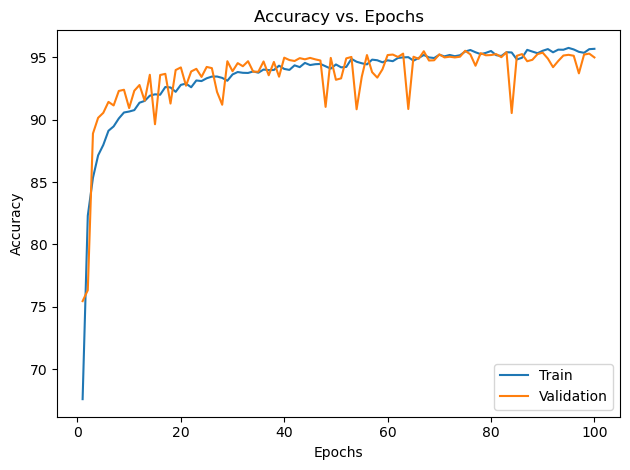

In [18]:
if params.MODEL_TYPE == "Regression":
    pass
else:
    plot_metric_vs_epoch(
        training_stats,
        x="epochs_ran",
        y1="train_acc",
        y2="valid_acc",
        title="Accuracy vs. Epochs",
        x_axis_label="Epochs",
        y_axis_label="Accuracy",
        params=params,
        model_name=params.MODEL_NAME,
    )

/home/lippincm/Documents/ML/Interstellar_Analysis/MLP_Model/model_training/notebooks/../../MLP_utils/utils.py:953: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/home/lippincm/Documents/ML/Interstellar_Analysis/MLP_Model/model_training/notebooks/../../MLP_utils/utils.py:954: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



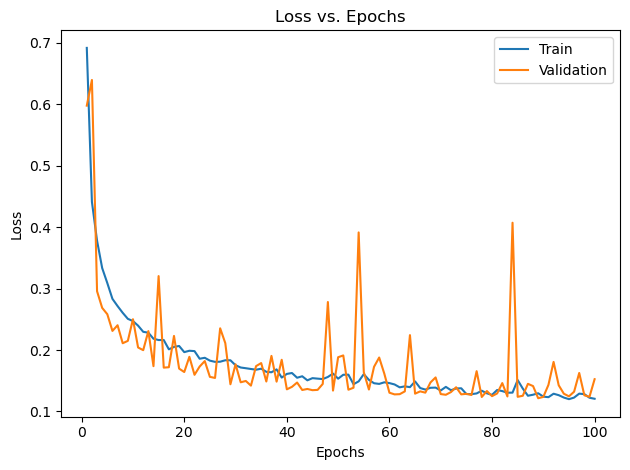

In [19]:
plot_metric_vs_epoch(
    training_stats,
    x="epochs_ran",
    y1="train_loss",
    y2="valid_loss",
    title="Loss vs. Epochs",
    x_axis_label="Epochs",
    y_axis_label="Loss",
    params=params,
    model_name=params.MODEL_NAME,
)

In [20]:
# calling the testing function and outputting list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    y_pred_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
elif params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      3081
           1       0.91      0.96      0.93      1186
           2       0.94      0.94      0.94       987

    accuracy                           0.95      5254
   macro avg       0.94      0.95      0.94      5254
weighted avg       0.95      0.95      0.95      5254

Precision for class 0: 0.968138068370395
Recall for class 0: 0.94677052904901
Precision for class 1: 0.9104716227018386
Recall for class 1: 0.9603709949409781
Precision for class 2: 0.9353535353535354
Recall for class 2: 0.9381965552178319
3


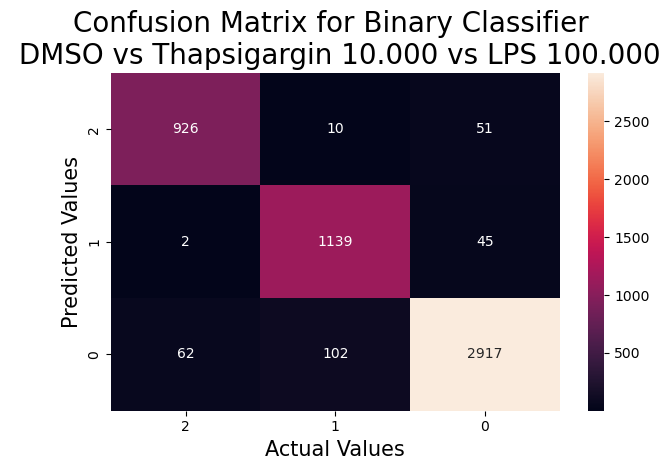

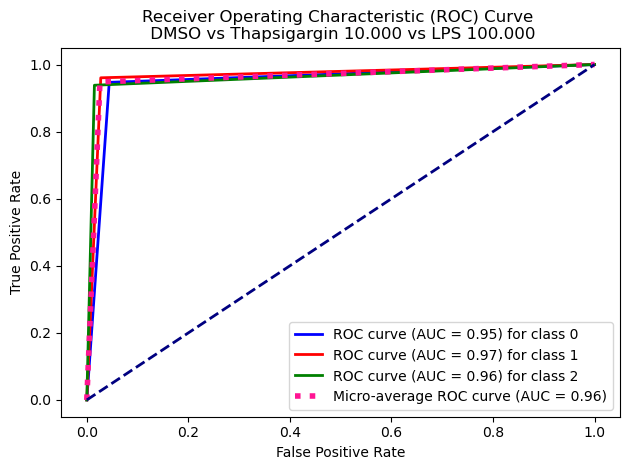

In [21]:
# Call visualization function
# calling the testing function and outputing list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_test,
        params,
        test_name=f"{params.MODEL_NAME}_testing",
        model_name=params.MODEL_NAME,
        title=title,
    )
elif params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_test,
        params,
        y_pred_prob_list,
        test_name=f"{params.MODEL_NAME}_testing",
        model_name=params.MODEL_NAME,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [22]:
for i, j in zip(
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique(),
    df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique(),
):
    print(i, j)

0 DMSO_0.100_DMSO_0.025
2 Thapsigargin_10.000_DMSO_0.025
1 LPS_100.000_DMSO_0.025


#### look at the feature weights of the model

In [23]:
# get all paramters from pytorch model
lst = []
for name, param in model.named_parameters():
    # print(name, param.shape)
    lst.append(param)
feature_weights = model[0].weight.grad[0].detach().cpu().numpy()

In [24]:
col_list = []
for col in df_values.columns:
    # print(col)
    col_list.append(col)

In [25]:
# remove last 4 columns from col_list that are not features
col_list = col_list[:-4]

In [26]:
pd.set_option("display.max_colwidth", None)

df1 = pd.DataFrame(zip(col_list, feature_weights), columns=["feature", "weight"])
# change weight collumn to float
df1["weight"] = df1["weight"].astype(float)
# sort by weight
df1 = df1.sort_values(by=["weight"], ascending=False)
df1

,feature,weight
1812,Cells_Texture_InverseDifferenceMoment_CorrPM_3_01_256,0.077313
2756,Nuclei_Texture_InverseDifferenceMoment_CorrGasdermin_3_01_256,0.076138
2763,Nuclei_Texture_InverseDifferenceMoment_CorrPM_3_00_256,0.073361
2764,Nuclei_Texture_InverseDifferenceMoment_CorrPM_3_01_256,0.072019
2755,Nuclei_Texture_InverseDifferenceMoment_CorrGasdermin_3_00_256,0.071570
...,...,...
2161,Nuclei_Intensity_MedianIntensity_CorrPM,-0.090088
2121,Nuclei_Intensity_IntegratedIntensity_CorrPM,-0.091543
2413,Nuclei_RadialDistribution_ZernikeMagnitude_CorrPM_4_0,-0.093353
2126,Nuclei_Intensity_LowerQuartileIntensity_CorrPM,-0.098551


In [27]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df_holdout.columns[df_holdout.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df_holdout[df_metadata]
df_values = df_holdout.drop(columns=df_metadata)

In [28]:
df_descriptive

,Metadata_cell_type,Metadata_Well,Metadata_number_of_singlecells,Metadata_incubation inducer (h),Metadata_inhibitor,Metadata_inhibitor_concentration,Metadata_inhibitor_concentration_unit,Metadata_inducer1,Metadata_inducer1_concentration,Metadata_inducer1_concentration_unit,...,Metadata_inducer2_concentration,Metadata_inducer2_concentration_unit,Metadata_ImageNumber,Metadata_Plate,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose
336238,SH-SY5Y,I14,4837,6,DMSO,0.025,%,DMSO,0.1,%,...,0.0,None,32,*70117_20230210MM1_Gasdermin514_CP_BC430856,1,1,5,5,DMSO,0.100
336239,SH-SY5Y,I14,4837,6,DMSO,0.025,%,DMSO,0.1,%,...,0.0,None,32,*70117_20230210MM1_Gasdermin514_CP_BC430856,2,2,6,6,DMSO,0.100
336240,SH-SY5Y,I14,4837,6,DMSO,0.025,%,DMSO,0.1,%,...,0.0,None,32,*70117_20230210MM1_Gasdermin514_CP_BC430856,3,3,7,7,DMSO,0.100
336241,SH-SY5Y,I14,4837,6,DMSO,0.025,%,DMSO,0.1,%,...,0.0,None,32,*70117_20230210MM1_Gasdermin514_CP_BC430856,4,4,9,9,DMSO,0.100
336242,SH-SY5Y,I14,4837,6,DMSO,0.025,%,DMSO,0.1,%,...,0.0,None,32,*70117_20230210MM1_Gasdermin514_CP_BC430856,5,5,10,10,DMSO,0.100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528609,SH-SY5Y,J21,4126,6,DMSO,0.025,%,LPS,100.0,µg_per_ml,...,0.0,None,332,*70117_20230210MM1_Gasdermin514_CP_BC430856,183,183,192,192,LPS,100.000
528610,SH-SY5Y,J21,4126,6,DMSO,0.025,%,LPS,100.0,µg_per_ml,...,0.0,None,332,*70117_20230210MM1_Gasdermin514_CP_BC430856,186,186,195,195,LPS,100.000
528611,SH-SY5Y,J21,4126,6,DMSO,0.025,%,LPS,100.0,µg_per_ml,...,0.0,None,332,*70117_20230210MM1_Gasdermin514_CP_BC430856,241,241,251,251,LPS,100.000
528612,SH-SY5Y,J21,4126,6,DMSO,0.025,%,LPS,100.0,µg_per_ml,...,0.0,None,332,*70117_20230210MM1_Gasdermin514_CP_BC430856,250,250,260,260,LPS,100.000


In [29]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
)
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ],
    axis=1,
)
df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]

In [30]:
test_data = Dataset_formatter(
    torch.FloatTensor(df_values_X.values), torch.FloatTensor(df_values_Y.values)
)

# convert data class into a dataloader to be compatible with pytorch
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1)

In [31]:
# calling the testing function and outputting list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    y_pred_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
elif params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(df_values_Y):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      4837
           1       0.97      0.90      0.94      4126
           2       0.97      0.94      0.95      3346

    accuracy                           0.94     12309
   macro avg       0.95      0.94      0.94     12309
weighted avg       0.94      0.94      0.94     12309

Precision for class 0: 0.8896030245746692
Recall for class 0: 0.9729170973744056
Precision for class 1: 0.9745139253809774
Recall for class 1: 0.8989335918565197
Precision for class 2: 0.9738562091503268
Recall for class 2: 0.9351464435146444
3


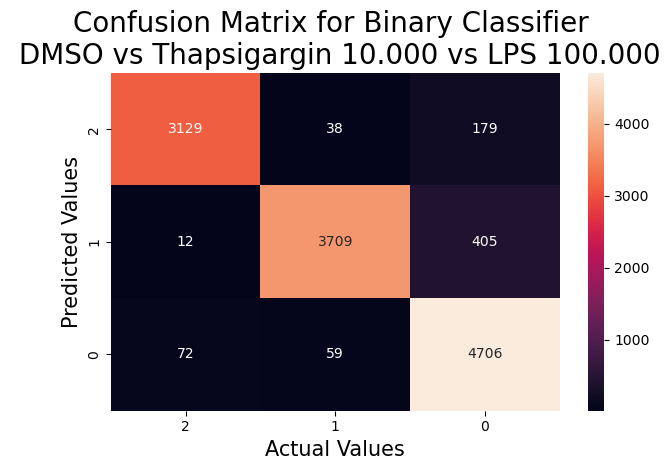

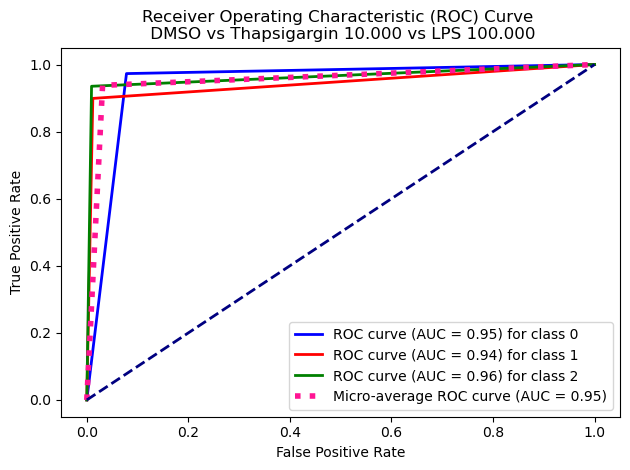

In [32]:
# Call visualization function
# calling the testing function and outputing list values of tested model

if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    confusion_matrix_df = results_output(
        y_pred_list,
        df_values_Y,
        params,
        test_name=f"{params.MODEL_NAME}_hold_out",
        model_name=params.MODEL_NAME,
        title=title,
    )
elif params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        df_values_Y,
        params,
        y_pred_prob_list,
        test_name=f"{params.MODEL_NAME}_hold_out",
        model_name=params.MODEL_NAME,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [33]:
for i, j in zip(
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique(),
    df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique(),
):
    print(i, j)

0 DMSO_0.100_DMSO_0.025
2 Thapsigargin_10.000_DMSO_0.025
1 LPS_100.000_DMSO_0.025
